# Hospital Price Transparency Data Collection & Price Variation Visualization (Abridged)

This code sample is derived from my work on my capstone project (in progress, Fall 2021). My team and I are working to evaluate the compliance of hospitals in Southwestern Pennsylvania with a CMS hospital price transparency rule, and to visualize inter- and intra-hospital price variation for shoppable health services in the region.

The hospital price transparency rule from the Centers for Medicare & Medicaid Services took effect on January 1, 2021. This rule mandates that hospitals provide gross, cash, and negotiated prices for the procedures they offer. These prices must be provided in both a machine-readable format and a consumer-friendly option, each having different requirements. [See Details](https://www.cms.gov/hospital-price-transparency).

As part of this project, we collected this pricing information for 64 procedures from 34 hospitals in Southwestern Pennsylvania. With this dataset, we are currently working to create a dashboard to visualize inter- and intra-hospital price variation.

In this code sample, I collect and process the data for just 3 of these hospitals and 5 of these procedures. I then visualize price variation for insurer-negotiated rates both across and within these hospitals.

## Table of Contents

1. [Data Collection and Cleaning](#data)
    1. [Collecting Hospital Data](#collecting)
        1. [UPMC Presbyterian Shadyside Hospital](#upmc)
        2. [Butler Memorial Hospital](#butler)
        3. [ACMH Hospital](#acmh)
    2. [Append & Standardize Combined Hospital Data](#append)
2. [Visualizing Price Variation (Negotiated Rates)](#visualize)
3. [Hospital Information](#info)
4. [Sample Interpretations](#sample)

## Setup

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt

<a name="data"></a>
## Data Collection and Cleaning

In [2]:
# define the 5 procedures & corresponding codes
code_map = {'80048': 'Basic metabolic panel',
            '70450': 'CT scan, head or brain, without contrast',
            '72110': 'X-Ray, lower back, minimum four views',
            '77067': 'Mammography, screening, bilateral',
            '470': 'Major joint replacement or reattachment of lower extremity without major comorbid conditions or complications (MCC)'}

In [3]:
# create clean map for column names
col_names = {'variable': 'price_type_raw', 
             'value': 'price',
             'Hospital': 'hospital',
             'CPT/DRG': 'procedure_code',
             'CPT-4/DRG': 'procedure_code',
             'CPT/HCPCS': 'procedure_code'}

In [4]:
# create clean map for price types
pt_map = {'IP Price': 'Gross IP', 
          'OP Price': 'Gross OP', 
          'IP Cash Price': 'Cash IP',
          'OP Cash Price': 'Cash OP',
          'Min Rate': 'Min', 
          'Max Rate': 'Max',
          'Discounted Cash Price': 'Cash',
          'Std Price': 'Gross',
          'Hospital Price': 'Gross',
          'Cash Price':'Cash',
          'MIN': 'Min',
          'MAX': 'Max'}

<a name="collecting"></a>
### Collecting Hospital Data

Future work: where possible, standardize the cleaning process with loops & functions.

The three hospitals shown here have provided their data in relatively similar formats, and this collecting process could be streamlined. However, this is not true for the broader range of hospitals in this project. The price transparency rule does not clearly define a standard data format, so there is a good deal of variation across hospitals.

<a name="upmc"></a>
#### UPMC Presbyterian Shadyside Hosptial

In [5]:
# JSON url
url = "https://cdn.upmc.com/-/media/upmc/locations/hospitals/documents/cdm-json-files/presbyterian-shadyside-standard-charges.json?la=en&rev=ad4d6c5eb22e46a8b95dfa1bf60b5539&hash=025826A6AF5C5B91962631C8DDC7D158&_ga=2.246655876.1660312782.1632322333-2067049313.1631911503&_gac=1.246621872.1631400896.EAIaIQobChMIx4a69YH48gIVkOd3Ch2KUgGVEAAYASAAEgJ18PD_BwE"

# request data, create dataframe
headers = {'Content-Type': 'application/json'}

response = requests.get(url, headers = headers)
if response.status_code == 200:
    df_upmc = pd.DataFrame(json.loads(response.content.decode('utf-8')))

# filter dataset by procedure code
df_upmc['CPT/DRG'] = df_upmc['CPT/DRG'].astype(str)
df_upmc = df_upmc[df_upmc['CPT/DRG'].isin(code_map.keys())]

In [6]:
# view
df_upmc.shape
df_upmc.columns
df_upmc.head(2)

,Hospital,Description,CPT/DRG,Multiplier,IP Price,OP Price,IP Cash Price,OP Cash Price,Min Rate,Max Rate,...,CCBHO,FIDELIS CARE OF NEW YORK,GEISINGER HP-FAMILY,MOLINA OF NY,THE HEALTH PLAN,UPMC Comm,BC Comm,Aetna Comm,United Comm,Cigna Comm
1565,UPMC Presbyterian Shadyside,CT HEAD WO CONTRAST,70450,1.0,3658,2438,2926.4,1950.4,85.25,780.16,...,109.4662,109.4662,109.4662,109.4662,109.4662,267.72,659.713287,714.334,699.706,780.16
1634,UPMC Presbyterian Shadyside,SPINE LUMBOSAC MIN 4 VWS,72110,1.0,1438,959,1150.4,767.2,24.75,306.88,...,43.0591,43.0591,43.0591,43.0591,43.0591,109.26,149.629622,280.987,275.233,306.88


In [7]:
# select ID columns
cols_id = ['Hospital', 'Description', 'CPT/DRG', 'Multiplier']

cols_val = []
for item in df_upmc.columns.tolist():
    if item not in cols_id:
        cols_val.append(item)
        
# melt dataframe - wide to long
df_upmc = df_upmc.reset_index()
df_upmc_long = pd.melt(df_upmc, 
                       id_vars = cols_id,
                       value_vars = cols_val)

In [8]:
# rename columns
df_upmc_long.rename(columns = col_names, inplace = True)

# select and reorder columns
df_upmc_long = df_upmc_long[['hospital', 'procedure_code', 'price_type_raw', 'price']]

In [9]:
# drop missing and bundled prices
df_upmc_long = df_upmc_long.dropna(subset = ['price'])
df_upmc_long = df_upmc_long[df_upmc_long['price'] != 'Bundled']

# temporarily change price to string for appending
df_upmc_long['price'] = df_upmc_long['price'].astype(str)

In [10]:
# view
print(df_upmc_long.shape)
df_upmc_long.head()

(198, 4)


,hospital,procedure_code,price_type_raw,price
0,UPMC Presbyterian Shadyside,70450,IP Price,3658
1,UPMC Presbyterian Shadyside,72110,IP Price,1438
2,UPMC Presbyterian Shadyside,77067,IP Price,342
3,UPMC Presbyterian Shadyside,80048,IP Price,260
4,UPMC Presbyterian Shadyside,80048,IP Price,260


<a name="butler"></a>
#### Butler Memorial Hosptial

In [11]:
# read data, strip spaces from column names
df_bmh = pd.read_csv('https://www.butlerhealthsystem.org/documents/250965274_BMH_Standardcharges.csv', dtype = str)
df_bmh.rename(columns=lambda x: x.strip(), inplace = True)

# filter dataset by procedure code
df_bmh['hospital'] = 'Butler Memorial Hospital'
df_bmh = df_bmh[df_bmh['CPT-4/DRG'].isin(code_map.keys())]

In [12]:
# view
df_bmh.shape
df_bmh.columns
df_bmh.head(2)

,Facility,Mnemonic,Description,Rev Code,Service Unit,Generic Dept,CPT-4/DRG,SOI,Std Price,Discounted Cash Price,...,HMK - Community Blue - Comm,Humana Commercial,UHC Commercial,UPMC - Commercial,Intergroup Commercial,Multiplan Commercial,Private Health Care Services - Commercial,Min,Max,hospital
6434,Buler Memorial Hospital,1600006,CT Head Brain wo Contrast,351,CT Scan,4490000,70450,NaN,"$1,154.00",$311.58,...,$219.59,$865.50,$807.80,$604.60,$923.20,"$1,038.60",$807.80,$85.25,"$1,038.60",Butler Memorial Hospital
6722,Buler Memorial Hospital,1532175,Mammo Screen Digital Bilat,403,Other Imaging Services,4510000,77067,NaN,$416.00,$112.32,...,$202.67,$312.00,$291.20,$406.19,$332.80,$374.40,$291.20,$-,$406.19,Butler Memorial Hospital


In [13]:
# drop unnecessary columns
df_bmh = df_bmh.drop(columns = ['Mnemonic', 'Rev Code', 'Service Unit', 'Generic Dept', 'SOI', 'Facility'])

In [14]:
# select ID columns, melt dataframe
cols_id = ['hospital', 'Description', 'CPT-4/DRG']

cols_val = []
for item in df_bmh.columns.tolist():
    if item not in cols_id:
        cols_val.append(item)
        
# melt dataframe - wide to long
df_bmh = df_bmh.reset_index()
df_bmh_long = pd.melt(df_bmh, 
                      id_vars = cols_id,
                      value_vars = cols_val)

In [15]:
# rename columns
df_bmh_long.rename(columns = col_names, inplace = True)

# select and reorder columns
df_bmh_long = df_bmh_long[['hospital', 'procedure_code', 'price_type_raw', 'price']]

In [16]:
# view
print(df_bmh_long.shape)
df_bmh_long.head()

(546, 4)


,hospital,procedure_code,price_type_raw,price
0,Butler Memorial Hospital,70450,Std Price,"$1,154.00"
1,Butler Memorial Hospital,77067,Std Price,$416.00
2,Butler Memorial Hospital,77067,Std Price,$416.00
3,Butler Memorial Hospital,77067,Std Price,$416.00
4,Butler Memorial Hospital,77067,Std Price,$416.00


<a name="acmh"></a>
#### ACMH Hosptial

In [17]:
# read data
df_acmh = pd.read_csv('https://www.acmh.org/Files/Admin/ACMH-Price-Transparency-Final.csv')

# filter dataset by procedure code
df_acmh = df_acmh[df_acmh['CPT/HCPCS'].isin(code_map.keys())]

# hospital name
df_acmh['hospital'] = 'ACMH Hospital'

In [18]:
# view
df_acmh.shape
df_acmh.columns
df_acmh.head(2)

,Charge Code/APC Package,Description,Hospital Price,Revenue Code,CPT/HCPCS,NDC,Cash Price,Unnamed: 7,Blue Cross Commercial,Blue Cross Chip,...,UPMC For Life,UHC,United Healthcare Medicare,Cigna,Aetna Commercial,Aetna Medicare,Unnamed: 20,MIN,MAX,hospital
3149,72110,LS SPINE MIN 4 VWS,274,320.0,72110,NaN,120.56,NaN,227.41,101.62,...,101.87,158.92,101.87,124.67,250.6,103.91,NaN,71.31,250.6,ACMH Hospital
3150,72110,LS SPINE MIN 4 VWS,274,320.0,72110,NaN,120.56,NaN,227.41,101.62,...,101.87,158.92,101.87,124.67,250.6,103.91,NaN,71.31,250.6,ACMH Hospital


In [19]:
# drop unnecessary columns
df_acmh = df_acmh.drop(columns = ['Charge Code/APC Package', 'Revenue Code', 'NDC'])

In [20]:
# select ID columns, melt dataframe
cols_id = ['hospital', 'Description', 'CPT/HCPCS']

cols_val = []
for item in df_acmh.columns.tolist():
    if item not in cols_id:
        cols_val.append(item)

# melt dataframe - wide to long
df_acmh = df_acmh.reset_index()
df_acmh_long = pd.melt(df_acmh, 
                      id_vars = cols_id,
                      value_vars = cols_val)

In [21]:
# rename columns
df_acmh_long.rename(columns = col_names, inplace = True)

# select and reorder columns
df_acmh_long = df_acmh_long[['hospital', 'procedure_code', 'price_type_raw', 'price']]

In [22]:
# view
print(df_acmh_long.shape)
df_acmh_long.head()

(396, 4)


,hospital,procedure_code,price_type_raw,price
0,ACMH Hospital,72110,Hospital Price,274
1,ACMH Hospital,72110,Hospital Price,274
2,ACMH Hospital,72110,Hospital Price,274
3,ACMH Hospital,72110,Hospital Price,274
4,ACMH Hospital,72110,Hospital Price,274


<a name="append"></a>
### Append & Standardize Combined Hospital Data

In [23]:
# append hospital data
df_all = df_upmc_long.append(df_bmh_long).append(df_acmh_long).reset_index(drop=True)

In [24]:
# map raw to clean price types
df_all['price_type_clean'] = df_all['price_type_raw'].map(pt_map)
df_all['price_type_clean'] = df_all['price_type_clean'].fillna('Negotiated')

# map raw to clean description name
df_all['procedure_desc_clean'] = df_all['procedure_code'].map(code_map)

In [25]:
# drop duplicates (some rows repeated due to hospital variations of procedure name)
df_all = df_all.drop_duplicates()

# drop blank rows (i.e. no price for that type/procedure)
df_all = df_all.dropna(subset = ['price'])

In [26]:
# convert prices to float
df_all['price'] = df_all['price'].str.replace(',', '').str.replace('$', '').str.replace('-', '').str.strip()
df_all = df_all[df_all['price'] != '']

df_all['price'] = df_all['price'].apply(pd.to_numeric)

<ipython-input-26-f4a014d0357f>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_all['price'] = df_all['price'].str.replace(',', '').str.replace('$', '').str.replace('-', '').str.strip()


In [27]:
# rearrange columns, view
df_all = df_all[['hospital', 'procedure_code', 'procedure_desc_clean', 'price_type_raw', 'price_type_clean', 'price']]
df_all.head()

,hospital,procedure_code,procedure_desc_clean,price_type_raw,price_type_clean,price
0,UPMC Presbyterian Shadyside,70450,"CT scan, head or brain, without contrast",IP Price,Gross IP,3658.0
1,UPMC Presbyterian Shadyside,72110,"X-Ray, lower back, minimum four views",IP Price,Gross IP,1438.0
2,UPMC Presbyterian Shadyside,77067,"Mammography, screening, bilateral",IP Price,Gross IP,342.0
3,UPMC Presbyterian Shadyside,80048,Basic metabolic panel,IP Price,Gross IP,260.0
5,UPMC Presbyterian Shadyside,470,Major joint replacement or reattachment of low...,IP Price,Gross IP,95094.0


In [28]:
# create dataframe with negotiated prices only
df_neg = df_all[df_all['price_type_clean'] == 'Negotiated']

<a name="visualize"></a>
## Visualizing Price Variation (Negotiated Rates)

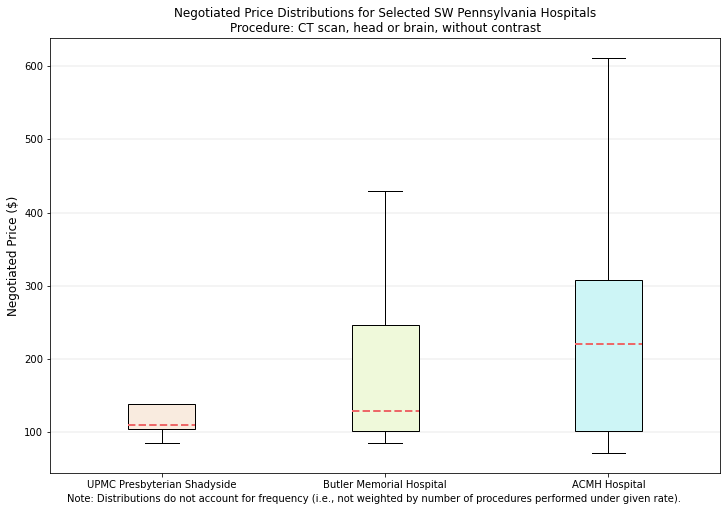

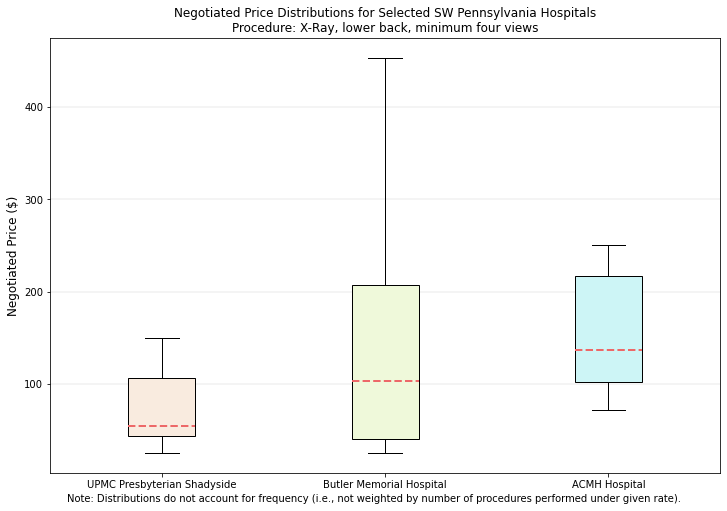

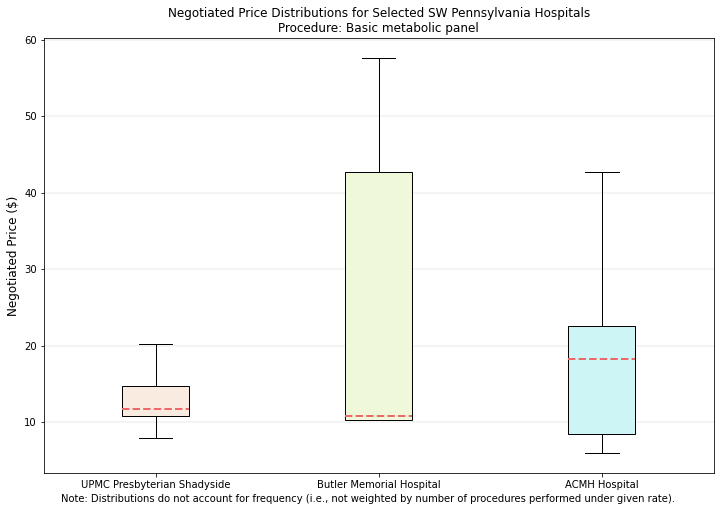

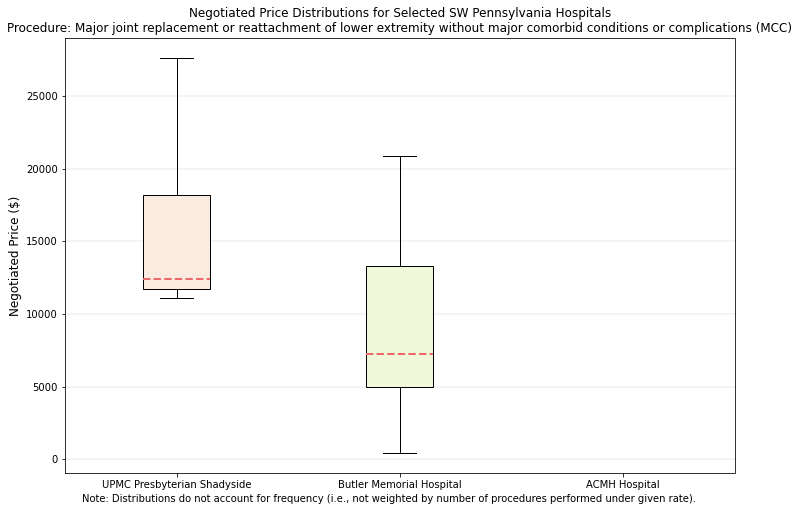

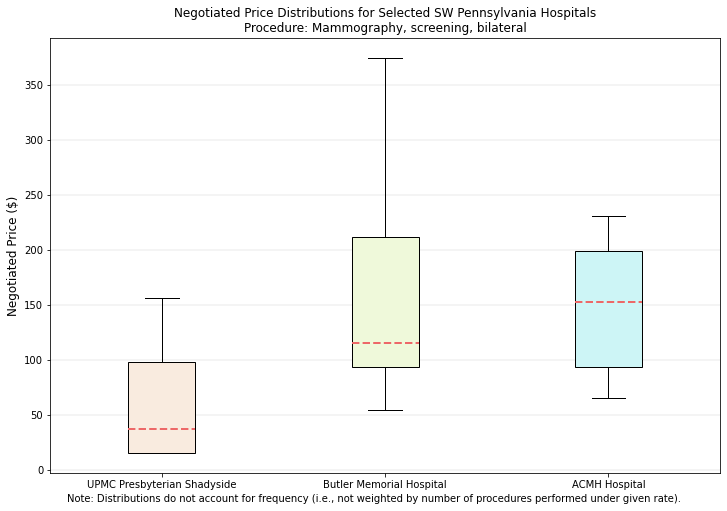

In [29]:
# box plots demonstrate both inter- and intra-hospital negotiated price variation

# create procedure list
procedure_list = df_neg['procedure_desc_clean'].unique().tolist()

# loop through procedures, plotting hospitals side-by-side
for p in procedure_list:
    upmc_prices = df_neg[(df_neg['hospital'] == 'UPMC Presbyterian Shadyside') & (df_neg['procedure_desc_clean'] == p)][['hospital', 'price']]
    bmh_prices = df_neg[(df_neg['hospital'] == 'Butler Memorial Hospital') & (df_neg['procedure_desc_clean'] == p)][['hospital', 'price']]
    acmh_prices = df_neg[(df_neg['hospital'] == 'ACMH Hospital') & (df_neg['procedure_desc_clean'] == p)][['hospital', 'price']]

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.grid(color = 'grey', axis = 'y', linestyle = '-', linewidth = 0.2, alpha = 0.8)

    ax.set_title(f'Negotiated Price Distributions for Selected SW Pennsylvania Hospitals\nProcedure: {p}')

    data = [upmc_prices['price'], bmh_prices['price'], acmh_prices['price']]
    labels = df_all['hospital'].unique().tolist()
    bp = ax.boxplot(data, labels = labels, showfliers = False, patch_artist = True, medianprops = dict(linestyle = '--', linewidth = 2, color = '#ed6868'))
    ax.set_ylabel('Negotiated Price ($)', fontsize = 12)
    
    colors = ['#F9EBDF', '#EFF9DA', '#CDF5F6']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        
    plt.figtext(0.5, 0.075, 'Note: Distributions do not account for frequency (i.e., not weighted by number of procedures performed under given rate).', 
                wrap=True, horizontalalignment='center', fontsize=10)
    
    plt.show()

<a name="info"></a>
## Hospital Information

When comparing shoppable services, self-insured employers and consumers may wish to also consider factors like: health system, hospital size (bed count), quality of care, and geographic location. These factors are analyzed in the larger project, but presented only briefly here for context.

[UPMC Presbyterian](https://www.upmc.com/locations/hospitals/presbyterian)
* County: Allgeheny
* Health System: UPMC
* [Bed Count](https://data.cms.gov/provider-characteristics/hospitals-and-other-facilities/provider-of-services-file-hospital-non-hospital-facilities): 1577
* [CMS Star Quality Rating](https://data.cms.gov/provider-data/dataset/xubh-q36u): 3

[Butler Memorial](https://www.butlerhealthsystem.org/)
* County: Butler
* Health System: Butler Health System
* [Bed Count](https://data.cms.gov/provider-characteristics/hospitals-and-other-facilities/provider-of-services-file-hospital-non-hospital-facilities): 294
* [CMS Star Quality Rating](https://data.cms.gov/provider-data/dataset/xubh-q36u): 4

[ACMH Hospital](https://www.acmh.org/)
* County: Armstrong
* Health System: Independent
* [Bed Count](https://data.cms.gov/provider-characteristics/hospitals-and-other-facilities/provider-of-services-file-hospital-non-hospital-facilities): 154
* [CMS Star Quality Rating](https://data.cms.gov/provider-data/dataset/xubh-q36u): 4

<a name="sample"></a>
## Sample Observations and Interpretations

Note: The distribution visualizations above do not account for frequency (i.e., not weighted by number of procedures performed under given rate).

For the major joint replacement procedure, UPMC Presbyterian and Butler both show a wide range of prices (intra-hospital variation) while ACMH does not appear to offer the procedure. UPMC Presbyterian's prices for this procedure generally tend to be higher than those at Butler (inter-hospital variation).

A more common procedure, a mammogram, is offered at all three hospitals. While UPMC Presbyterian's range of prices is quite large, the middle 50% of the distribution falls almost entirely below the middle 50% of the price distributions at Butler and ACMH.

In general, UPMC Presbyterian tends to have less intra-hospital price variation than Butler and ACMH. In general, ACMH tends to have a higher median prices for these procedures than Butler and ACMH.